## read Bepi data







In [4]:
import numpy as np
import scipy.io
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import  DateFormatter
from datetime import timedelta
import seaborn as sns
import datetime
import astropy
import astropy.constants as const
from sunpy.time import parse_time
import time
import pickle
import sys
import os
import urllib
import json
import importlib
import pandas as pd
import copy
import openpyxl
import h5py
import heliopy.data.spice as spicedata
import heliopy.spice as spice
import heliosat



from heliocats import plot as hp
importlib.reload(hp) #reload again while debugging

from heliocats import data as hd
importlib.reload(hd) #reload again while debugging

from heliocats import cats as hc
importlib.reload(hc) #reload again while debugging

from heliocats import stats as hs
importlib.reload(hs) #reload again while debugging

#where the in situ data files are located is read 
#from config.py 
import config
importlib.reload(config)
from config import data_path
from config import data_path_ML


########### make directories first time if not there

resdir='results'
if os.path.isdir(resdir) == False: os.mkdir(resdir)

datadir='data'
if os.path.isdir(datadir) == False: os.mkdir(datadir)

indexdir='icmecat/indices_icmecat' 
if os.path.isdir(indexdir) == False: os.mkdir(indexdir) 

catdir='icmecat'
if os.path.isdir(catdir) == False: os.mkdir(catdir)

icplotsdir='icmecat/plots_icmecat/' 
if os.path.isdir(icplotsdir) == False: os.mkdir(icplotsdir) 

plt.rcParams["figure.figsize"] = (15,5)


from astropy.constants import au
#define AU in km
AU=au.value/1e3
print('done')


raw_data_path='/nas/helio/data/BepiColombo/cruise_ob/'


done


## get Wind data

In [5]:
filewin=data_path+'wind_2018_2020_sept_heeq.p'
[win,hwin]=pickle.load(open(filewin, "rb" ) )

#set wind awkward data points to nan
windspike_ind=np.where(win.time > parse_time('2020-04-20 17:08').datetime)[0]
win.bt[windspike_ind[0:2]]=np.nan
win.bx[windspike_ind[0:2]]=np.nan
win.by[windspike_ind[0:2]]=np.nan
win.bz[windspike_ind[0:2]]=np.nan


#set wind awkward data points to nan
windspike_ind=np.where(win.time > parse_time('2020-04-21 01:20').datetime)[0]
win.bt[windspike_ind[0:1]]=np.nan
win.bx[windspike_ind[0:1]]=np.nan
win.by[windspike_ind[0:1]]=np.nan
win.bz[windspike_ind[0:1]]=np.nan





## read Bepi Colombo MAG data

In [3]:
#get data from OB SENSOR, ECLIPJ2000



filelist_all=os.listdir(raw_data_path)
#only tab files
filelist = [i for i in filelist_all if i.endswith('.tab')]
filesort=np.sort(filelist)


#start with March 1 2020 
#filesort=filesort[346:]

#set time range for 1 minute interpolation
t_start = datetime.datetime(2019, 3, 6)
t_end = datetime.datetime(2020, 9, 23)



#make array 
bm=np.zeros(86400*len(filelist),dtype=[('time',object),('bx', float),('by', float),\
        ('bz', float),('x', float),('y', float),('z', float)])  
bm = bm.view(np.recarray) 
               
counter=0            

#x y z
#SC POSITION X COMPONENT, ECLIPJ2000 COORDINATES. VALUE IS GIVEN IN KM. THE SC POSITION IS STATED AS THE DISTANCE TO SUN.
#MAGNETIC FIELD X COMPONENT, 1-SECOND-AVERAGED CALIBRATED DATA,   ECLIPJ2000 COORDINATES, OB SENSOR. VALUE IS GIVEN IN NANOTESLA.

#go through all files
for file in filesort:
    print(file)
    braw=np.loadtxt(raw_data_path+file,delimiter=",",dtype=[('time','<U30'),('tsc','<U30'),('x', float),\
                                            ('y', float),('z', float),('bx', float),('by', float),\
                                            ('bz', float),('t1', float),('t2', float),('t3', float)])
    braw = braw.view(np.recarray) 
            

    bm.time[counter:counter+len(braw)]=parse_time(braw.time).datetime
    bm.bx[counter:counter+len(braw)]=braw.bx
    bm.by[counter:counter+len(braw)]=braw.by
    bm.bz[counter:counter+len(braw)]=braw.bz

    bm.x[counter:counter+len(braw)]=braw.x
    bm.y[counter:counter+len(braw)]=braw.y
    bm.z[counter:counter+len(braw)]=braw.z


    counter=counter+len(braw)

bm1=bm[0:counter]

#------------------------------------------- interpolate to 1 minute

# create an array with 1 minute resolution between t start and end
time = [ t_start + datetime.timedelta(minutes=1*n) for n in range(int ((t_end - t_start).days*60*24))]
time_mat=mdates.date2num(time) 

bmag=np.zeros(np.size(time_mat),dtype=[('time',object),('bx', float),('by', float),\
        ('bz', float),('bt', float),('bxe', float),('bye', float), ('bze', float),\
        ('xe', float),('ye', float),('ze', float),\
        ('x', float),('y', float),('z', float),\
        ('r', float),('lat', float),('lon', float)])  
bmag = bmag.view(np.recarray) 

tm_mat=mdates.date2num(bm1.time) 

bmag.time=time
bmag.bxe = np.interp(time_mat, tm_mat, bm1.bx)
bmag.bye = np.interp(time_mat, tm_mat, bm1.by)
bmag.bze = np.interp(time_mat, tm_mat, bm1.bz)
bmag.bt =np.sqrt(bmag.bxe**2+bmag.bye**2+bmag.bze**2)


#------------------------------------------ add position
frame='ECLIPJ2000'
spice.furnish(spicedata.get_kernel('bepi_pred'))
tra=spice.Trajectory('BEPICOLOMBO MPO')
tra.generate_positions(time,'Sun',frame)
tra.change_units(astropy.units.AU)  
[bepi_r_ej2, bepi_lat_ej2, bepi_lon_ej2]=hd.cart2sphere(tra.x,tra.y,tra.z)


#----------------------- make bepi position in HEE
frame='HEE'
spice.furnish(spicedata.get_kernel('bepi_pred'))
trahee=spice.Trajectory('BEPICOLOMBO MPO')
trahee.generate_positions(time,'Sun',frame)
trahee.change_units(astropy.units.AU)  
[bepi_r_hee, bepi_lat_hee, bepi_lon_hee]=hd.cart2sphere(trahee.x,trahee.y,trahee.z)


#put values into array
bmag.r=bepi_r_hee
#convert to degree
bmag.lat=np.rad2deg(bepi_lat_hee)
bmag.lon=np.rad2deg(bepi_lon_hee)

bmag.x=trahee.x.value
bmag.y=trahee.y.value
bmag.z=trahee.z.value

#E2K position from data files
bmag.xe = np.interp(time_mat, tm_mat, bm1.x/AU)
bmag.ye = np.interp(time_mat, tm_mat, bm1.y/AU)
bmag.ze = np.interp(time_mat, tm_mat, bm1.z/AU)



##################################################
print('bepi position eclipj2000 x y z mean AU from heliopy:')
print(np.mean(bmag.x))
print(np.mean(bmag.y))
print(np.mean(bmag.z))

print('bepi position eclipj2000 x y z mean AU from data files:')
print(np.mean(bmag.xe))
print(np.mean(bmag.ye))
print(np.mean(bmag.ze))


print('bepi position HEE x y z mean AU from heliopy:')
print(np.mean(trahee.x))
print(np.mean(trahee.y))
print(np.mean(trahee.z))


print('done')


######################## save Bepi HEE and EJ2 data
#filemag=data_path+'bepi_2020_march_sept_e2k.p'
filemag=data_path+'bepi_2019_2020_e2k.p'
pickle.dump(bmag, open(filemag, "wb"))




KeyboardInterrupt: 

In [14]:
#filemag='data/bepi_2020_march_sept_e2k.p'
filemag=data_path+'bepi_2019_2020_e2k.p'
bm=pickle.load(open(filemag, "rb" ) ) 


%matplotlib

sns.set_context("talk")     
sns.set_style('darkgrid')

plt.figure(1,figsize=(15, 10),dpi=100)

ax = plt.subplot(111)
plt.title('BepiColombo MPO/MAG')
ax.plot(bm.time, bm.bt, "k-", lw=1, label='Btotal')
ax.plot(bm.time, bm.bxe, "r-", color="xkcd:magenta", lw=1, label='Br')
ax.plot(bm.time, bm.bye, "g-", color="xkcd:orange", lw=1,label='Bt')
ax.plot(bm.time, bm.bze, "b-", color="xkcd:azure", lw=1,label='Bn')
plt.ylabel('B [nT, RTN]')
ax.set_ylim([-30,30])
ax.legend()


plt.tight_layout()



plt.savefig('results/bepi_cruise.png',dpi=100)


Using matplotlib backend: Qt5Agg


/home/cmoestl/miniconda/envs/helio/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/cmoestl/miniconda/envs/helio/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/cmoestl/miniconda/envs/helio/lib/python3.7/site-packages/ipykernel/eventloops.py:106: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  app.exec_()


In [75]:
#get Earth trajectory in ECLIPJ2000
earth=spice.Trajectory('399')  #399 for Earth, not barycenter (because of moon)
earth.generate_positions(bmag.time,'Sun','ECLIPJ2000')
earth.change_units(astropy.units.AU)  
earth_x_ej2=earth.x.value
earth_y_ej2=earth.y.value
earth_z_ej2=earth.z.value

sc_len=len(bmag.bt)

#unit vectors of EJ2 basis
ej_x=[1,0,0]
ej_y=[0,1,0]
ej_z=[0,0,1]

#project into new system HEE
for i in np.arange(0,sc_len):   
    #make unit vectors of HEE in basis of EJ2
    hee_x=[earth_x_ej2[i],earth_y_ej2[i],earth_z_ej2[i]]/np.linalg.norm([earth_x_ej2[i],earth_y_ej2[i],earth_z_ej2[i]])
    hee_z=[0,0,1]
    hee_y=np.cross(hee_z,hee_x)

    bmag.bx[i]=bmag.bxe[i]*np.dot(ej_x,hee_x)+bmag.bye[i]*np.dot(ej_y,hee_x)+bmag.bze[i]*np.dot(ej_z,hee_x)
    bmag.by[i]=bmag.bxe[i]*np.dot(ej_x,hee_y)+bmag.bye[i]*np.dot(ej_y,hee_y)+bmag.bze[i]*np.dot(ej_z,hee_y)
    bmag.bz[i]=bmag.bxe[i]*np.dot(ej_x,hee_z)+bmag.bye[i]*np.dot(ej_y,hee_z)+bmag.bze[i]*np.dot(ej_z,hee_z)

  
######################## save Bepi HEE
filemag='data/bepi_2020_march_sept_hee.p'
pickle.dump(bmag, open(filemag, "wb"))

print('done')

## April 2020 CME

In [6]:
#--------------------------------------------- CME1 April 2020
#OB SENSOR, ECLIPJ2000

#filelist=['data/bepi_mag_cruise/mag_der_sc_ob_a001_e2k_00000_20200415.tab',
#          'data/bepi_mag_cruise/mag_der_sc_ob_a001_e2k_00000_20200416.tab',
#          'data/bepi_mag_cruise/mag_der_sc_ob_a001_e2k_00000_20200417.tab',
#          'data/bepi_mag_cruise/mag_der_sc_ob_a001_e2k_00000_20200418.tab',
#          'data/bepi_mag_cruise/mag_der_sc_ob_a001_e2k_00000_20200419.tab',
#          'data/bepi_mag_cruise/mag_der_sc_ob_a001_e2k_00000_20200420.tab',
#          'data/bepi_mag_cruise/mag_der_sc_ob_a001_e2k_00000_20200421.tab',]
#          'data/bepi_mag_cruise/mag_der_sc_ob_a001_e2k_00000_20200424.tab',
#          'data/bepi_mag_cruise/mag_der_sc_ob_a001_e2k_00000_20200425.tab']

filelist=[raw_data_path+'mag_der_sc_ob_a001_e2k_00000_20200415.tab',
          raw_data_path+'mag_der_sc_ob_a001_e2k_00000_20200416.tab',
          raw_data_path+'mag_der_sc_ob_a001_e2k_00000_20200417.tab',
          raw_data_path+'mag_der_sc_ob_a001_e2k_00000_20200418.tab',
          raw_data_path+'mag_der_sc_ob_a001_e2k_00000_20200419.tab',
          raw_data_path+'mag_der_sc_ob_a001_e2k_00000_20200420.tab',
          raw_data_path+'mag_der_sc_ob_a001_e2k_00000_20200421.tab',]
#          'data/bepi_mag_cruise/mag_der_sc_ob_a001_e2k_00000_20200424.tab',
#          'data/bepi_mag_cruise/mag_der_sc_ob_a001_e2k_00000_20200425.tab']




#make array 
bm=np.zeros(86400*len(filelist),dtype=[('time',object),('bx', float),('by', float),\
        ('bz', float),('x', float),('y', float),('z', float)])  
bm = bm.view(np.recarray) 
               
counter=0            

#x y z
#SC POSITION X COMPONENT, ECLIPJ2000 COORDINATES. VALUE IS GIVEN IN KM. THE SC POSITION IS STATED AS THE DISTANCE TO SUN.
#MAGNETIC FIELD X COMPONENT, 1-SECOND-AVERAGED CALIBRATED DATA,   ECLIPJ2000 COORDINATES, OB SENSOR. VALUE IS GIVEN IN NANOTESLA.

#go through all files
for file in filelist:
    print(file)
    braw=np.loadtxt(file,delimiter=",",dtype=[('time','<U30'),('tsc','<U30'),('x', float),\
                                            ('y', float),('z', float),('bx', float),('by', float),\
                                            ('bz', float),('t1', float),('t2', float),('t3', float)])
    braw = braw.view(np.recarray) 
            

    bm.time[counter:counter+len(braw)]=parse_time(braw.time).datetime
    bm.bx[counter:counter+len(braw)]=braw.bx
    bm.by[counter:counter+len(braw)]=braw.by
    bm.bz[counter:counter+len(braw)]=braw.bz

    bm.x[counter:counter+len(braw)]=braw.x
    bm.y[counter:counter+len(braw)]=braw.y
    bm.z[counter:counter+len(braw)]=braw.z


    counter=counter+len(braw)

bm1=bm[0:counter]

#interpolate to 1 minute
t_start = datetime.datetime(2020, 4, 15)
t_end = datetime.datetime(2020, 4, 22)

# create an array with 1 minute resolution between t start and end
time = [ t_start + datetime.timedelta(minutes=1*n) for n in range(int ((t_end - t_start).days*60*24))]
time_mat=mdates.date2num(time) 

bmag=np.zeros(np.size(time_mat),dtype=[('time',object),('bx', float),('by', float),\
        ('bz', float),('bt', float),('bxe', float),('bye', float), ('bze', float),\
        ('xe', float),('ye', float),('ze', float),\
        ('x', float),('y', float),('z', float),\
        ('r', float),('lat', float),('lon', float)])  
bmag = bmag.view(np.recarray) 

tm_mat=mdates.date2num(bm1.time) 

bmag.time=time
bmag.bxe = np.interp(time_mat, tm_mat, bm1.bx)
bmag.bye = np.interp(time_mat, tm_mat, bm1.by)
bmag.bze = np.interp(time_mat, tm_mat, bm1.bz)
bmag.bt =np.sqrt(bmag.bxe**2+bmag.bye**2+bmag.bze**2)


## position
#frame='ECLIPJ2000'
#spice.furnish(spicedata.get_kernel('bepi_pred'))
#tra=spice.Trajectory('BEPICOLOMBO MPO')
#tra.generate_positions(time,'Sun',frame)
#tra.change_units(astropy.units.AU)  
#[bmag.r, bmag.lat, bmag.lon]=hd.cart2sphere(tra.x,tra.y,tra.z)


## bepi position in HEEQ
frame='HEEQ'
spice.furnish(spicedata.get_kernel('bepi_pred'))
traheeq=spice.Trajectory('BEPICOLOMBO MPO')
traheeq.generate_positions(time,'Sun',frame)
traheeq.change_units(astropy.units.AU)  
[bmag.r, bmag.lat, bmag.lon]=hd.cart2sphere(traheeq.x,traheeq.y,traheeq.z)


#convert to degree
bmag.lat=np.rad2deg(bmag.lat)
bmag.lon=np.rad2deg(bmag.lon)

bmag.x=traheeq.x.value
bmag.y=traheeq.y.value
bmag.z=traheeq.z.value

#E2K position from data files
#bmag.xe = np.interp(time_mat, tm_mat, bm1.x/AU)
#bmag.ye = np.interp(time_mat, tm_mat, bm1.y/AU)
#bmag.ze = np.interp(time_mat, tm_mat, bm1.z/AU)

#print('bepi position eclipj2000 x y z mean AU from heliopy:')
#print(np.mean(bmag.x))
#print(np.mean(bmag.y))
#print(np.mean(bmag.z))

#print('bepi position eclipj2000 x y z mean AU from data files:')
#print(np.mean(bmag.xe))
#print(np.mean(bmag.ye))
#print(np.mean(bmag.ze))


filemag='data/bepi_april2020_icme_e2k.p'
pickle.dump(bmag, open(filemag, "wb"))


print('done')

######################### convert E2K to HEE to HEEQ

#get Earth trajectory in ECLIPJ2000
earth=spice.Trajectory('399')  #399 for Earth, not barycenter (because of moon)
earth.generate_positions(bmag.time,'Sun','ECLIPJ2000')
earth.change_units(astropy.units.AU)  
earth_x_ej2=earth.x.value
earth_y_ej2=earth.y.value
earth_z_ej2=earth.z.value

sc_len=len(bmag.bt)

#unit vectors of EJ2 basis
ej_x=[1,0,0]
ej_y=[0,1,0]
ej_z=[0,0,1]

#project into new system HEE
for i in np.arange(0,sc_len):   
    #make unit vectors of HEE in basis of EJ2
    hee_x=[earth_x_ej2[i],earth_y_ej2[i],earth_z_ej2[i]]/np.linalg.norm([earth_x_ej2[i],earth_y_ej2[i],earth_z_ej2[i]])
    hee_z=[0,0,1]
    hee_y=np.cross(hee_z,hee_x)

    bmag.bx[i]=bmag.bxe[i]*np.dot(ej_x,hee_x)+bmag.bye[i]*np.dot(ej_y,hee_x)+bmag.bze[i]*np.dot(ej_z,hee_x)
    bmag.by[i]=bmag.bxe[i]*np.dot(ej_x,hee_y)+bmag.bye[i]*np.dot(ej_y,hee_y)+bmag.bze[i]*np.dot(ej_z,hee_y)
    bmag.bz[i]=bmag.bxe[i]*np.dot(ej_x,hee_z)+bmag.bye[i]*np.dot(ej_y,hee_z)+bmag.bze[i]*np.dot(ej_z,hee_z)

  
#[earth_r, earth_lat, earth_lon]=hd.cart2sphere(earth.x,earth.y,earth.z)

#l1_r=np.mean(earth_r)-0.01
#bepi_r=np.mean(bmag.r)
#print('L1 at AU ',l1_r)
#print('bepi at AU ',bepi_r)
#print('diff', l1_r-bepi_r)
#print('time delay for 350 km/s in minutes', (l1_r-bepi_r)*AU/(350*60))
#print('bepi at longitude',np.mean(bmag.lon))


######################## save Bepi HEE and EJ2 data
filemag='data/bepi_april2020_icme_hee.p'
pickle.dump(bmag, open(filemag, "wb"))


bmagq=hd.convert_HEE_to_HEEQ(bmag)

filemag='data/bepi_april2020_icme_heeq.p'
pickle.dump(bmagq, open(filemag, "wb"))




######################### convert HEEQ to RTN

sc_len=len(bmagq.bt)


bmagrtn=copy.deepcopy(bmagq)

#unit vectors of HEEQ basis
heeq_x=[1,0,0]
heeq_y=[0,1,0]
heeq_z=[0,0,1]

#project into new system RTN
for i in np.arange(0,sc_len):
   
    #make unit vectors of RTN in basis of HEEQ
    rtn_r=[bmagq.x[i],bmagq.y[i],bmagq.z[i]]/np.linalg.norm([bmagq.x[i],bmagq.y[i],bmagq.z[i]])
    rtn_t=np.cross(heeq_z,rtn_r)
    rtn_n=np.cross(rtn_r,rtn_t)

    bmagrtn.bx[i]=bmagq.bx[i]*np.dot(heeq_x,rtn_r)+bmagq.by[i]*np.dot(heeq_y,rtn_r)+bmagq.bz[i]*np.dot(heeq_z,rtn_r)
    bmagrtn.by[i]=bmagq.bx[i]*np.dot(heeq_x,rtn_t)+bmagq.by[i]*np.dot(heeq_y,rtn_t)+bmagq.bz[i]*np.dot(heeq_z,rtn_t)
    bmagrtn.bz[i]=bmagq.bx[i]*np.dot(heeq_x,rtn_n)+bmagq.by[i]*np.dot(heeq_y,rtn_n)+bmagq.bz[i]*np.dot(heeq_z,rtn_n)


filemag='data/bepi_april2020_icme_rtn.p'
pickle.dump(bmagrtn, open(filemag, "wb"))

np.savetxt('data/bepi_apr2020_icme_rtn.txt',bmagrtn,header='time, bx [RTN,nT],\
           by [RTN,nT], bz [RTN,nT], bt [nT], bxe [EJ2000,nT], bye [EJ2000,nT], \
           bze [EJ2000,nT],  xe [EJ2000, AU], ye [EJ2000, AU], ze [EJ2000, AU], \
           x [HEEQ, AU], y [HEEQ, AU], z [HEEQ, AU], r [AU], lat [HEEQ,deg], \
           lon [HEEQ,deg]',fmt='%16s %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e ')



print('done')


/nas/helio/data/BepiColombo/cruise_ob/mag_der_sc_ob_a001_e2k_00000_20200415.tab
/nas/helio/data/BepiColombo/cruise_ob/mag_der_sc_ob_a001_e2k_00000_20200416.tab
/nas/helio/data/BepiColombo/cruise_ob/mag_der_sc_ob_a001_e2k_00000_20200417.tab
/nas/helio/data/BepiColombo/cruise_ob/mag_der_sc_ob_a001_e2k_00000_20200418.tab
/nas/helio/data/BepiColombo/cruise_ob/mag_der_sc_ob_a001_e2k_00000_20200419.tab
/nas/helio/data/BepiColombo/cruise_ob/mag_der_sc_ob_a001_e2k_00000_20200420.tab
/nas/helio/data/BepiColombo/cruise_ob/mag_der_sc_ob_a001_e2k_00000_20200421.tab
done
conversion HEE to HEEQ
HEE to HEEQ done
done


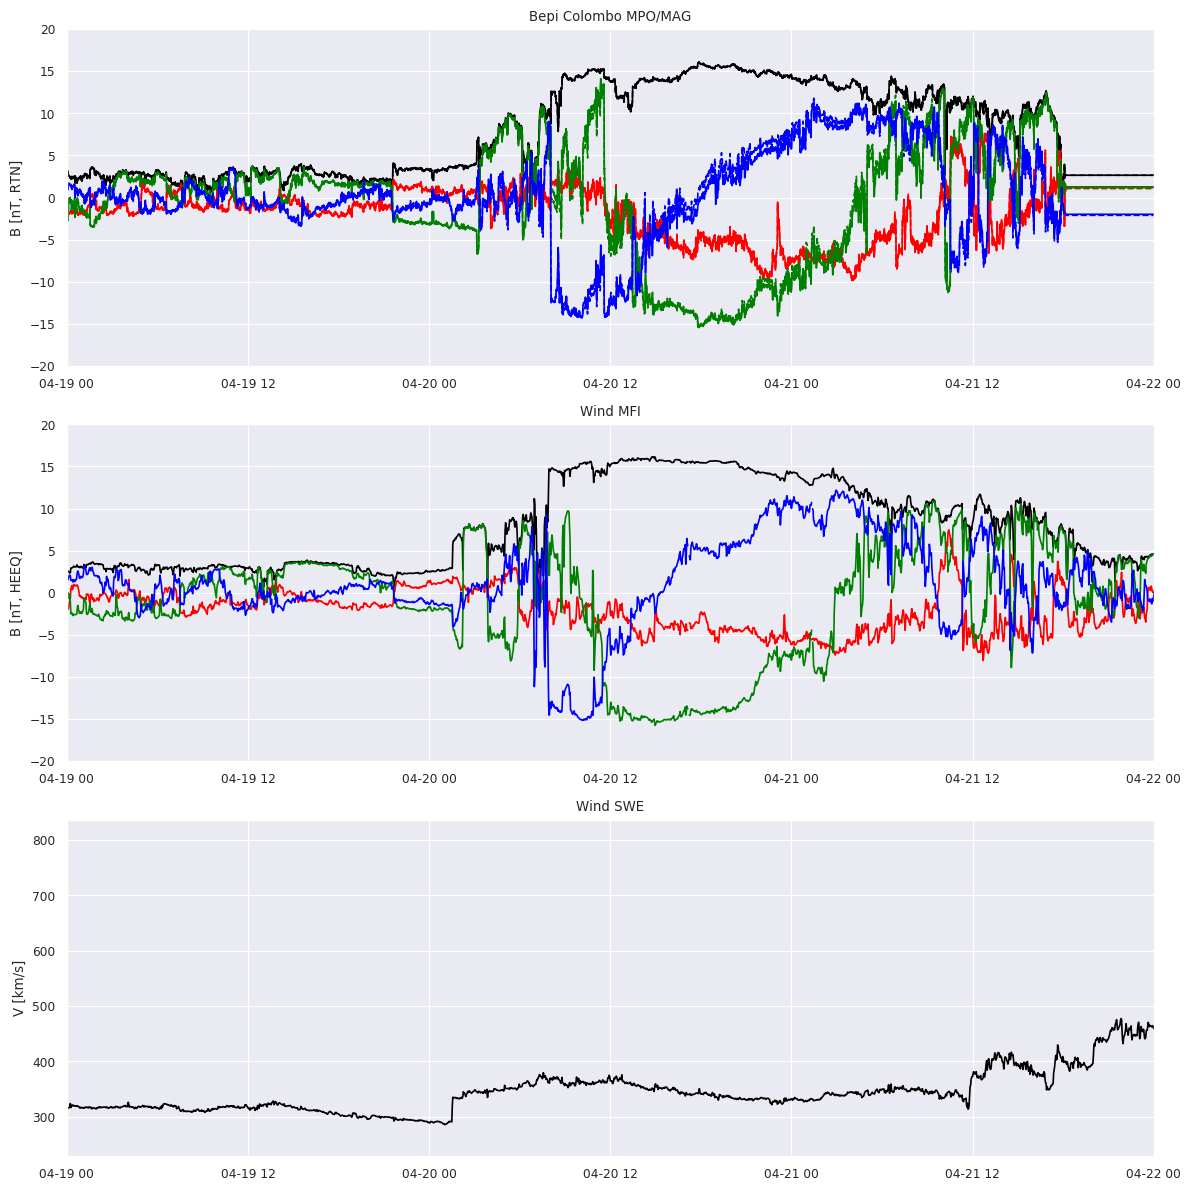

In [7]:
#filemag='data/bepi_2020_march_sept_e2k.p'
filemag='data/bepi_april2020_icme_hee.p'
bepi=pickle.load(open(filemag, "rb" ) ) 


filemag='data/bepi_april2020_icme_rtn.p'
bmagrtn=pickle.load(open(filemag, "rb" ) ) 

%matplotlib  inline



sns.set_context("paper")     
sns.set_style('darkgrid')

plt.figure(1, figsize=(12,12), dpi=100)

ax1 = plt.subplot(311) 
ax1.plot_date(bepi.time,bepi.bt,'k--')
ax1.plot_date(bepi.time,bepi.bx,'r--')
ax1.plot_date(bepi.time,bepi.by,'g--')
ax1.plot_date(bepi.time,bepi.bz,'b--')

ax1.plot_date(bmagrtn.time,bmagrtn.bt,'k-')
ax1.plot_date(bmagrtn.time,bmagrtn.bx,'r-')
ax1.plot_date(bmagrtn.time,bmagrtn.by,'g-')
ax1.plot_date(bmagrtn.time,bmagrtn.bz,'b-')



ax1.set_ylabel('B [nT, RTN]')
ax1.set_title('Bepi Colombo MPO/MAG')
ax1.set_ylim(-20,20)


ax2 = plt.subplot(312,sharex = ax1) 
ax2.plot_date(win.time,win.bt,'k-')
ax2.plot_date(win.time,win.bx,'r-')
ax2.plot_date(win.time,win.by,'g-')
ax2.plot_date(win.time,win.bz,'b-')


#bepi.time=bepi.time+timedelta(hours=-1.9)

#ax2.plot_date(bepi.time,bepi.bt,'k--')
#ax2.plot_date(bepi.time,bepi.bx,'r--')
#ax2.plot_date(bepi.time,bepi.by,'g--')
#ax2.plot_date(bepi.time,bepi.bz,'b--')



ax2.set_ylabel('B [nT, HEEQ]')
ax2.set_title('Wind MFI')
ax2.set_ylim(-20,20)

ax3 = plt.subplot(313,sharex = ax1) 
ax3.plot_date(win.time,win.vt,'k-')
ax3.set_ylabel('V [km/s]')
ax3.set_title('Wind SWE')



#all
plotstart=datetime.datetime(2020, 4, 19)
plotend=datetime.datetime(2020, 4,22)
ax1.set_xlim(plotstart,plotend)
ax2.set_xlim(plotstart,plotend)
ax3.set_xlim(plotstart,plotend)




plt.tight_layout()

#### old code

CME 1 April 2020

### projection of Bepi Colombo magnetic field components from EJ2000 to HEE coordinates




In [44]:
#get Earth trajectory in ECLIPJ2000
earth=spice.Trajectory('399')  #399 for Earth, not barycenter (because of moon)
earth.generate_positions(bmag.time,'Sun','ECLIPJ2000')
earth.change_units(astropy.units.AU)  
earth_x_ej2=earth.x.value
earth_y_ej2=earth.y.value
earth_z_ej2=earth.z.value

sc_len=len(bmag.bt)

#unit vectors of EJ2 basis
ej_x=[1,0,0]
ej_y=[0,1,0]
ej_z=[0,0,1]

#project into new system HEE
for i in np.arange(0,sc_len):   
    #make unit vectors of HEE in basis of EJ2
    hee_x=[earth_x_ej2[i],earth_y_ej2[i],earth_z_ej2[i]]/np.linalg.norm([earth_x_ej2[i],earth_y_ej2[i],earth_z_ej2[i]])
    hee_z=[0,0,1]
    hee_y=np.cross(hee_z,hee_x)

    bmag.bx[i]=bmag.bxe[i]*np.dot(ej_x,hee_x)+bmag.bye[i]*np.dot(ej_y,hee_x)+bmag.bze[i]*np.dot(ej_z,hee_x)
    bmag.by[i]=bmag.bxe[i]*np.dot(ej_x,hee_y)+bmag.bye[i]*np.dot(ej_y,hee_y)+bmag.bze[i]*np.dot(ej_z,hee_y)
    bmag.bz[i]=bmag.bxe[i]*np.dot(ej_x,hee_z)+bmag.bye[i]*np.dot(ej_y,hee_z)+bmag.bze[i]*np.dot(ej_z,hee_z)

  
[earth_r, earth_lat, earth_lon]=hd.cart2sphere(earth.x,earth.y,earth.z)

l1_r=np.mean(earth_r)-0.01
bepi_r=np.mean(bmag.r)
print('L1 at AU ',l1_r)
print('bepi at AU ',bepi_r)
print('diff', l1_r-bepi_r)
print('time delay for 350 km/s in minutes', (l1_r-bepi_r)*AU/(350*60))
print('bepi at longitude',np.mean(bmag.lon))


######################## save Bepi HEE and EJ2 data
filemag='data/bepi_april2020_icme_hee.p'
pickle.dump(bmag, open(filemag, "wb"))


print('done')

L1 at AU  0.9942738648041984
bepi at AU  1.0095693755076032
diff -0.015295510703404736
time delay for 350 km/s in minutes -108.96075392849559
bepi at longitude -1.0480192839990246
done



## Plot Bepi data April 2020 event

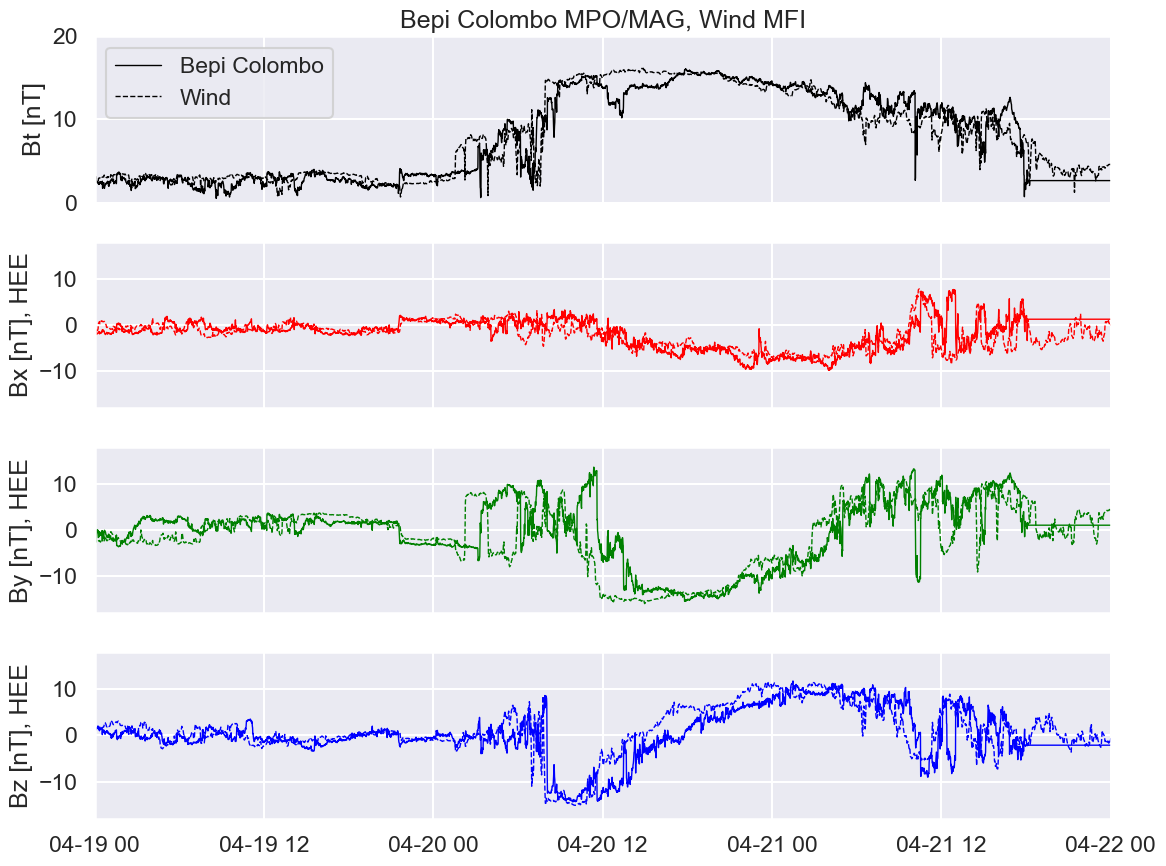

In [48]:
filemag='data/bepi_april2020_icme_hee.p'
be=pickle.load(open(filemag, "rb" ) ) 


#time shift
#be.time=be.time+timedelta(hours=-2)

sns.set_context("talk")     
sns.set_style('darkgrid')

plt.figure(1, figsize=(12,9), dpi=100)

#------------------------------ Bt
ax1 = plt.subplot(411) 
plt.title('Bepi Colombo MPO/MAG, Wind MFI')
ax1.plot_date(be.time, be.bt,'-k',label='Bepi Colombo', linewidth=1)
ax1.plot_date(win.time, win.bt,'--k',linewidth=1,label='Wind')
plt.setp(ax1.get_xticklabels(), visible=False)
plt.ylabel('Bt [nT]')
ax1.legend(loc=2)
ax1.set_ylim((0, 20))

#reverse win.bx and win.by for plotting GSE to HEE

ax2 = plt.subplot(412,sharex=ax1) 
ax2.plot_date(be.time, be.bx,'-r',label='Bepi Colombo',linewidth=1)
#ax2.plot_date(bm.time, bm.bxe,'-r',label='Bx',linewidth=3)
ax2.plot_date(win.time, -win.bx,'--r',linewidth=1,label='Wind')
plt.setp(ax2.get_xticklabels(), visible=False)
plt.ylabel('Bx [nT], HEE')
ax2.set_ylim((-18, 18))

ax3 = plt.subplot(413,sharex=ax1) 
ax3.plot_date(be.time, be.by,'-g',label='Bepi Colombo',linewidth=1)
#ax3.plot_date(bm.time, bm.bye,'-g',label='By',linewidth=3)
ax3.plot_date(win.time, -win.by,'--g',linewidth=1, label='Wind')
plt.setp(ax3.get_xticklabels(), visible=False)
plt.ylabel('By [nT], HEE')
ax3.set_ylim((-18, 18))

ax4 = plt.subplot(414,sharex=ax1) 
ax4.plot_date(be.time, be.bz,'-b',label='Bepi Colombo',linewidth=1)
#ax4.plot_date(bm.time, bm.bze,'-b',label='Bz',linewidth=3)
ax4.plot_date(win.time, win.bz,'--b',linewidth=1, label='Wind')
plt.ylabel('Bz [nT], HEE')
ax4.set_ylim((-18, 18))


#all
plotstart=datetime.datetime(2020, 4, 19)
plotend=datetime.datetime(2020, 4,22)
plt.xlim(plotstart,plotend)


#shock
#plotstart=datetime.datetime(2020, 4, 20,0,0)
#plotend=datetime.datetime(2020, 4,20,4,0)
#plt.xlim(plotstart,plotend)

plt.tight_layout()


plt.savefig('results/bepi_cme_april2020_hee.png',dpi=300)

## Save as txt


In [67]:
np.savetxt('results/bepi_apr2020_1min_hee.txt',be,header='time, bx [HEE,nT],\
           by [HEE,nT], bz [HEE,nT], bt [nT], bxe [EJ2000,nT], bye [EJ2000,nT], \
           bze [EJ2000,nT],  xe [EJ2000, AU], ye [EJ2000, AU], ze [EJ2000, AU], \
           x [HEE, AU], y [HEE, AU], z [HEE, AU], r [AU], lat [HEE,deg], \
           lon [HEE,deg]',fmt='%16s %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e ')


# CME 2 May 2020

In [80]:
########### CME2 May 2020

# t_start = datetime.datetime(2020, 4, 14)
# t_end = datetime.datetime(2020, 4, 21)

# create an array with 1 minute resolution between t start and end
# time = [ t_start + datetime.timedelta(minutes=1*n) for n in range(int ((t_end - t_start).days*60*24))]  
# time_mat=mdates.date2num(time) 

filelist=['data/bepi_mag_cruise/mag_der_sc_ob_a001_e2k_00000_20200524.tab',
          'data/bepi_mag_cruise/mag_der_sc_ob_a001_e2k_00000_20200525.tab',
          'data/bepi_mag_cruise/mag_der_sc_ob_a001_e2k_00000_20200526.tab',
          'data/bepi_mag_cruise/mag_der_sc_ob_a001_e2k_00000_20200527.tab',
          'data/bepi_mag_cruise/mag_der_sc_ob_a001_e2k_00000_20200528.tab',
          'data/bepi_mag_cruise/mag_der_sc_ob_a001_e2k_00000_20200529.tab',
          'data/bepi_mag_cruise/mag_der_sc_ob_a001_e2k_00000_20200530.tab',
          'data/bepi_mag_cruise/mag_der_sc_ob_a001_e2k_00000_20200531.tab']

#make array 
bm=np.zeros(86400*len(filelist),dtype=[('time',object),('bx', float),('by', float),\
        ('bz', float),('x', float),('y', float),('z', float)])  
bm = bm.view(np.recarray) 
               
counter=0            

#x y z
#SC POSITION X COMPONENT, ECLIPJ2000 COORDINATES. VALUE IS GIVEN IN KM. THE SC POSITION IS STATED AS THE DISTANCE TO SUN.
#MAGNETIC FIELD X COMPONENT, 1-SECOND-AVERAGED CALIBRATED DATA,   ECLIPJ2000 COORDINATES, OB SENSOR. VALUE IS GIVEN IN NANOTESLA.

#go through all files
for file in filelist:
    braw=np.loadtxt(file,delimiter=",",dtype=[('time','<U30'),('tsc','<U30'),('x', float),\
                                            ('y', float),('z', float),('bx', float),('by', float),\
                                            ('bz', float),('t1', float),('t2', float),('t3', float)])
    braw = braw.view(np.recarray) 
            

    bm.time[counter:counter+len(braw)]=parse_time(braw.time).datetime
    bm.bx[counter:counter+len(braw)]=braw.bx
    bm.by[counter:counter+len(braw)]=braw.by
    bm.bz[counter:counter+len(braw)]=braw.bz

    bm.x[counter:counter+len(braw)]=braw.x
    bm.y[counter:counter+len(braw)]=braw.y
    bm.z[counter:counter+len(braw)]=braw.z


    counter=counter+len(braw)

bm1=bm[0:counter]

#------------------------------------------- interpolate to 1 minute
t_start = datetime.datetime(2020, 5, 25)
t_end = datetime.datetime(2020, 5, 31)

# create an array with 1 minute resolution between t start and end
time = [ t_start + datetime.timedelta(minutes=1*n) for n in range(int ((t_end - t_start).days*60*24))]
time_mat=mdates.date2num(time) 

bmag=np.zeros(np.size(time_mat),dtype=[('time',object),('bx', float),('by', float),\
        ('bz', float),('bt', float),('bxe', float),('bye', float), ('bze', float),\
        ('xe', float),('ye', float),('ze', float),\
        ('x', float),('y', float),('z', float),\
        ('r', float),('lat', float),('lon', float)])  
bmag = bmag.view(np.recarray) 

tm_mat=mdates.date2num(bm1.time) 

bmag.time=time
bmag.bxe = np.interp(time_mat, tm_mat, bm1.bx)
bmag.bye = np.interp(time_mat, tm_mat, bm1.by)
bmag.bze = np.interp(time_mat, tm_mat, bm1.bz)
bmag.bt =np.sqrt(bmag.bxe**2+bmag.bye**2+bmag.bze**2)


#------------------------------------------ add position
frame='ECLIPJ2000'
spice.furnish(spicedata.get_kernel('bepi_pred'))
tra=spice.Trajectory('BEPICOLOMBO MPO')
tra.generate_positions(time,'Sun',frame)
tra.change_units(astropy.units.AU)  
[bepi_r_ej2, bepi_lat_ej2, bepi_lon_ej2]=hd.cart2sphere(tra.x,tra.y,tra.z)


#----------------------- make bepi position in HEE
frame='HEE'
spice.furnish(spicedata.get_kernel('bepi_pred'))
trahee=spice.Trajectory('BEPICOLOMBO MPO')
trahee.generate_positions(time,'Sun',frame)
trahee.change_units(astropy.units.AU)  
[bepi_r_hee, bepi_lat_hee, bepi_lon_hee]=hd.cart2sphere(trahee.x,trahee.y,trahee.z)


#put values into array
bmag.r=bepi_r_hee
#convert to degree
bmag.lat=np.rad2deg(bepi_lat_hee)
bmag.lon=np.rad2deg(bepi_lon_hee)

bmag.x=trahee.x.value
bmag.y=trahee.y.value
bmag.z=trahee.z.value

#E2K position from data files
bmag.xe = np.interp(time_mat, tm_mat, bm1.x/AU)
bmag.ye = np.interp(time_mat, tm_mat, bm1.y/AU)
bmag.ze = np.interp(time_mat, tm_mat, bm1.z/AU)



##################################################
print('bepi position eclipj2000 x y z mean AU from heliopy:')
print(np.mean(bmag.x))
print(np.mean(bmag.y))
print(np.mean(bmag.z))

print('bepi position eclipj2000 x y z mean AU from data files:')
print(np.mean(bmag.xe))
print(np.mean(bmag.ye))
print(np.mean(bmag.ze))


print('bepi position HEE x y z mean AU from heliopy:')
print(np.mean(trahee.x))
print(np.mean(trahee.y))
print(np.mean(trahee.z))
#get Earth trajectory in ECLIPJ2000
earth=spice.Trajectory('399')  #399 for Earth, not barycenter (because of moon)
earth.generate_positions(bmag.time,'Sun','ECLIPJ2000')
earth.change_units(astropy.units.AU)  
earth_x_ej2=earth.x.value
earth_y_ej2=earth.y.value
earth_z_ej2=earth.z.value

sc_len=len(bmag.bt)

#unit vectors of EJ2 basis
ej_x=[1,0,0]
ej_y=[0,1,0]
ej_z=[0,0,1]

#project into new system HEE
for i in np.arange(0,sc_len):   
    #make unit vectors of HEE in basis of EJ2
    hee_x=[earth_x_ej2[i],earth_y_ej2[i],earth_z_ej2[i]]/np.linalg.norm([earth_x_ej2[i],earth_y_ej2[i],earth_z_ej2[i]])
    hee_z=[0,0,1]
    hee_y=np.cross(hee_z,hee_x)

    bmag.bx[i]=bmag.bxe[i]*np.dot(ej_x,hee_x)+bmag.bye[i]*np.dot(ej_y,hee_x)+bmag.bze[i]*np.dot(ej_z,hee_x)
    bmag.by[i]=bmag.bxe[i]*np.dot(ej_x,hee_y)+bmag.bye[i]*np.dot(ej_y,hee_y)+bmag.bze[i]*np.dot(ej_z,hee_y)
    bmag.bz[i]=bmag.bxe[i]*np.dot(ej_x,hee_z)+bmag.bye[i]*np.dot(ej_y,hee_z)+bmag.bze[i]*np.dot(ej_z,hee_z)

  
[earth_r, earth_lat, earth_lon]=hd.cart2sphere(earth.x,earth.y,earth.z)

l1_r=np.mean(earth_r)-0.01
bepi_r=np.mean(bmag.r)
print('L1 at AU ',l1_r)
print('bepi at AU ',bepi_r)
print('diff', l1_r-bepi_r)
print('time delay for 350 km/s in minutes', (l1_r-bepi_r)*AU/(350*60))
print('bepi at longitude',np.mean(bmag.lon))


######################## save Bepi HEE and EJ2 data

filemag='data/bepi_may2020_icme_hee.p'
pickle.dump(bmag, open(filemag, "wb"))


print('done')



bepi position eclipj2000 x y z mean AU from heliopy:
0.9764020848576792
-0.09085536197087798
-0.019034129527578256
bepi position eclipj2000 x y z mean AU from data files:
-0.4673130704759043
-0.8616154613471197
-0.018934320714862483
bepi position HEE x y z mean AU from heliopy:
0.9764020848576792 AU
-0.09085536197087798 AU
-0.019034129527578256 AU
L1 at AU  1.0034264113972446
bepi at AU  0.9808065145532339
diff 0.02261989684401078
time delay for 350 km/s in minutes 161.1375430151268
bepi at longitude -5.316501338924752
done


## Plot CME 2 May 2020

<Figure size 1080x360 with 0 Axes>

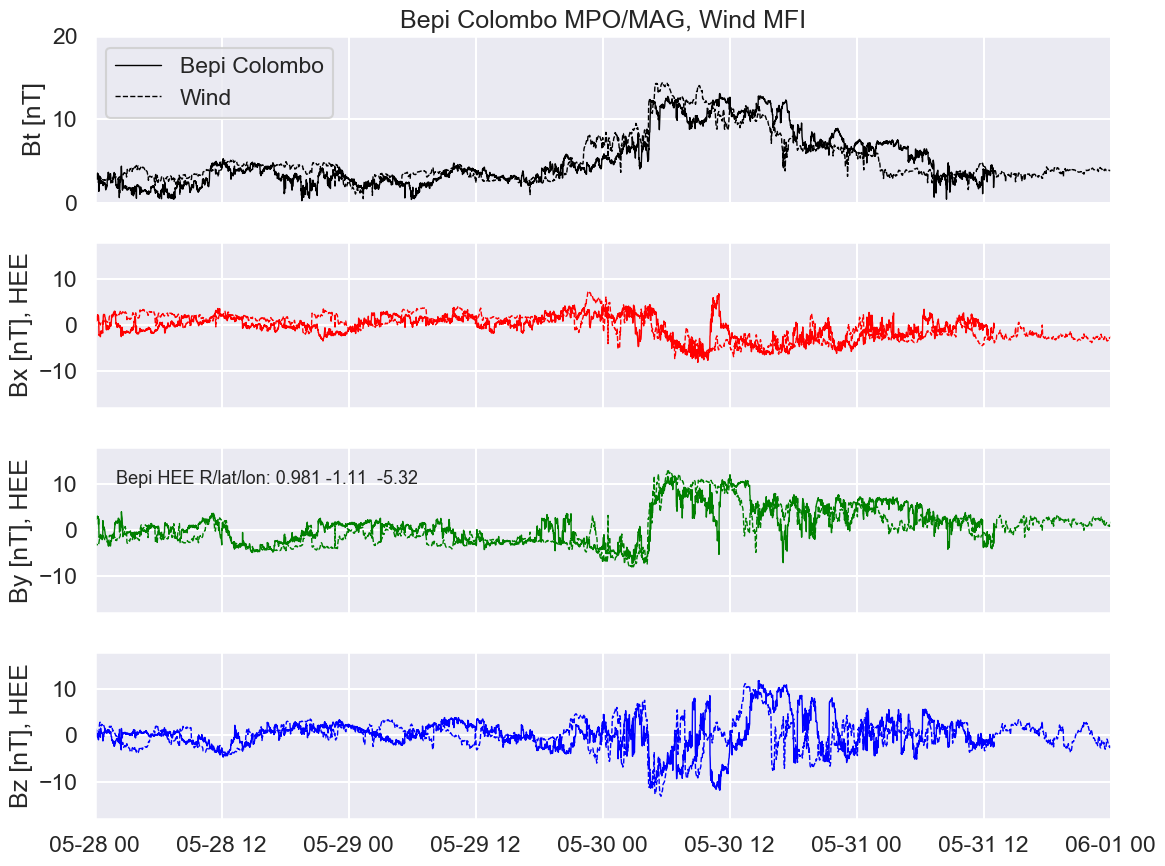

In [108]:
plt.figure(2)

filemag='data/bepi_may2020_icme_hee.p'
be=pickle.load(open(filemag, "rb" ) ) 

#time shift
be.time=be.time+timedelta(hours=13)

sns.set_context("talk")     
sns.set_style('darkgrid')

plt.figure(1, figsize=(12,9), dpi=100)

#------------------------------ Bt
ax1 = plt.subplot(411) 
plt.title('Bepi Colombo MPO/MAG, Wind MFI')
ax1.plot_date(be.time, be.bt,'-k',label='Bepi Colombo', linewidth=1)
ax1.plot_date(win.time, win.bt,'--k',linewidth=1,label='Wind')
plt.setp(ax1.get_xticklabels(), visible=False)
plt.ylabel('Bt [nT]')
ax1.legend(loc=2)
ax1.set_ylim((0, 20))

#reverse win.bx and win.by for plotting GSE to HEE

ax2 = plt.subplot(412,sharex=ax1) 
ax2.plot_date(be.time, be.bx,'-r',label='Bepi Colombo',linewidth=1)
#ax2.plot_date(bm.time, bm.bxe,'-r',label='Bx',linewidth=3)
ax2.plot_date(win.time, -win.bx,'--r',linewidth=1,label='Wind')
plt.setp(ax2.get_xticklabels(), visible=False)
plt.ylabel('Bx [nT], HEE')
ax2.set_ylim((-18, 18))

ax3 = plt.subplot(413,sharex=ax1) 
ax3.plot_date(be.time, be.by,'-g',label='Bepi Colombo',linewidth=1)
#ax3.plot_date(bm.time, bm.bye,'-g',label='By',linewidth=3)
ax3.plot_date(win.time, -win.by,'--g',linewidth=1, label='Wind')
plt.setp(ax3.get_xticklabels(), visible=False)
plt.ylabel('By [nT], HEE')
ax3.set_ylim((-18, 18))



#position on figure
textstart=plotstart+datetime.timedelta(hours=2)
ax3.text(textstart,10,'Bepi HEE R/lat/lon: '+str(np.round(np.mean(be.r),3))+' ' +str(np.round(np.mean(be.lat),2))+'  '+\
         str(np.round(np.mean(be.lon),2)),fontsize=13)



ax4 = plt.subplot(414,sharex=ax1) 
ax4.plot_date(be.time, be.bz,'-b',label='Bepi Colombo',linewidth=1)
#ax4.plot_date(bm.time, bm.bze,'-b',label='Bz',linewidth=3)
ax4.plot_date(win.time, win.bz,'--b',linewidth=1, label='Wind')
plt.ylabel('Bz [nT], HEE')
ax4.set_ylim((-18, 18))



#all
plotstart=datetime.datetime(2020, 5, 28)
plotend=datetime.datetime(2020, 6,1)
plt.xlim(plotstart,plotend)


#shock
#plotstart=datetime.datetime(2020, 4, 20,0,0)
#plotend=datetime.datetime(2020, 4,20,4,0)
#plt.xlim(plotstart,plotend)

plt.tight_layout()


plt.savefig('results/bepi_cme_may2020_shift13.png')



In [113]:
################# HELIOSAT new version

# bepi example
DATAPATH = "/nas/helio/data/BepiColombo/cruise_ob"
class BEPI_EXT(heliosat.BEPI):
    def get_data_files(self, *args):
        files = os.listdir(DATAPATH)
        files.sort()
        files = [os.path.join(DATAPATH, f) for f in files if f[-3:] == "tab"]
        range_start, range_end, data_key = args
        if range_end < range_start:
            raise ValueError("starting date must be after final date")
        data_key = self.resolve_data_key(data_key)
        # adjust ranges slightly
        range_start -= datetime.timedelta(hours=range_start.hour, minutes=range_start.minute,
                                          seconds=range_start.second)
        if range_end.hour == 0 and range_end.minute == 0 and range_end.second == 0:
            range_end -= datetime.timedelta(seconds=1)
        # filter out files
        # get date for each file
        files_dates = np.array([
            datetime.datetime.strptime(os.path.basename(_)[:-4][-8:], "%Y%m%d") for _ in files
        ])
        mask = (files_dates > range_start) & (files_dates < range_end)
        files_selected = np.array(files)[mask]
        files_selected_dates = np.array(files_dates)[mask]
        return files_selected, [self.get_data_version("mag", _) for _ in files_selected_dates]
_t = [datetime.datetime(2020, 4, 19) + datetime.timedelta(hours=0, minutes=15*i) for i in range(0, 4 * 24 * 3)]
bepi_t, bepi_b = BEPI_EXT().get_data(_t, "mag", frame="HEE", smoothing="kernel",
                                    smoothing_scale=240, cache=False, remove_nans=True, return_datetimes=True)
#BC_MPO_RTN          MPO Radial-Tangential-Normal Heliocentric
#BC_MMO_RTN          MMO Radial-Tangential-Normal Heliocentric (bearbeitet) 

KeyError: 'data_keys'

# read SolO data


In [ ]:
DATAPATH = "data/solo_mag/event1"

class SOIO_EXT(heliosat.SOIO):
    def get_data_files(self, *args):
        files = os.listdir(DATAPATH)
        files.sort()
        files = [os.path.join(DATAPATH, f) for f in files]
        return files, [self.get_data_version("mag", datetime.datetime.now())] * len(files)
  

a = SOIO_EXT()
#time for 7 days
time = [datetime.datetime(2020, 4, 15) + datetime.timedelta(minutes=i) for i in range(60 * 24 * 7 )]
time_mat=mdates.date2num(time) 


#_, b_soio = SOIO_EXT().get_data(t_soio, "mag", frame="HEEQ")

# t_soio = [datetime.datetime(2020, 5, 27) + datetime.timedelta(hours=i) for i in range(24 * 7)]
# _, b_soio = SOIO_EXT().get_data(t_soio, "mag", frame="HEEQ", cache=True, smoothing="kernel",
#                                 smoothing_scale=240, remove_nans=True)


#original data
print('get data')
t2, b_soio = SOIO_EXT().get_data(time, "mag")#,frame="HEEQ")
t1=parse_time(t2,format='unix').datetime
tm_mat=mdates.date2num(t1) 

smag=np.zeros(np.size(time),dtype=[('time',object),('bx', float),('by', float),\
        ('bz', float),('bt', float),\
        ('vt', float),('np', float), ('tp', float),\
                                   ('x', float),('y', float),('z', float),\
        ('r', float),('lat', float),('lon', float)])  
smag = smag.view(np.recarray) 

print('interpolate')
smag.time=time
smag.bx = np.interp(time_mat, tm_mat, b_soio[:, 0])
smag.by = np.interp(time_mat, tm_mat, b_soio[:, 1])
smag.bz = np.interp(time_mat, tm_mat, b_soio[:, 2])
smag.bt =np.sqrt(smag.bx**2+smag.by**2+smag.bz**2)


print('Solo position')


#add position

frame='HEEQ'
spice.furnish(spicedata.get_kernel('solo_2020'))
solo=spice.Trajectory('Solar Orbiter')
solo.generate_positions(smag.time, 'Sun',frame)
solo.change_units(astropy.units.AU)
[smag.r, smag.lat, smag.lon]=hd.cart2sphere(solo.x,solo.y,solo.z)


#convert to degree
smag.lat=np.rad2deg(smag.lat)
smag.lon=np.rad2deg(smag.lon)


smag.x=solo.x.value
smag.y=solo.y.value
smag.z=solo.z.value


#maybe use RTN to SCEQ or HEEQ from hd.

filemag='data/solo_april2020.p'
pickle.dump(smag, open(filemag, "wb"))



SolO times: 2020-04-19 05:07:00 2020-04-19 08:59:00 2020-04-20 09:15:00
HEEQ position of SolO r/lat/lon at icme_start_time: 0.806 -3.9 -4.61
HEEQ position of SolO r/lat/lon at mo_start_time: 0.805 -3.89 -4.56
HEEQ position of SolO r/lat/lon at mo_end_time: 0.799 -3.77 -4.28
SolO ICME duration hours  28.13
SolO MO duration hours  24.27

Wind times: 2020-04-20 01:34:00 2020-04-20 07:56:00 2020-04-21 11:18:00
Wind ICME duration hours  33.73
Wind MO duration hours  27.37
HEEQ position of Wind r/lat/lon at icme_start_time: 0.996 -5.21 0.19
HEEQ position of Wind r/lat/lon at mo_start_time: 0.996 -5.19 0.19
HEEQ position of Wind r/lat/lon at mo_end_time: 0.996 -5.09 0.18


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


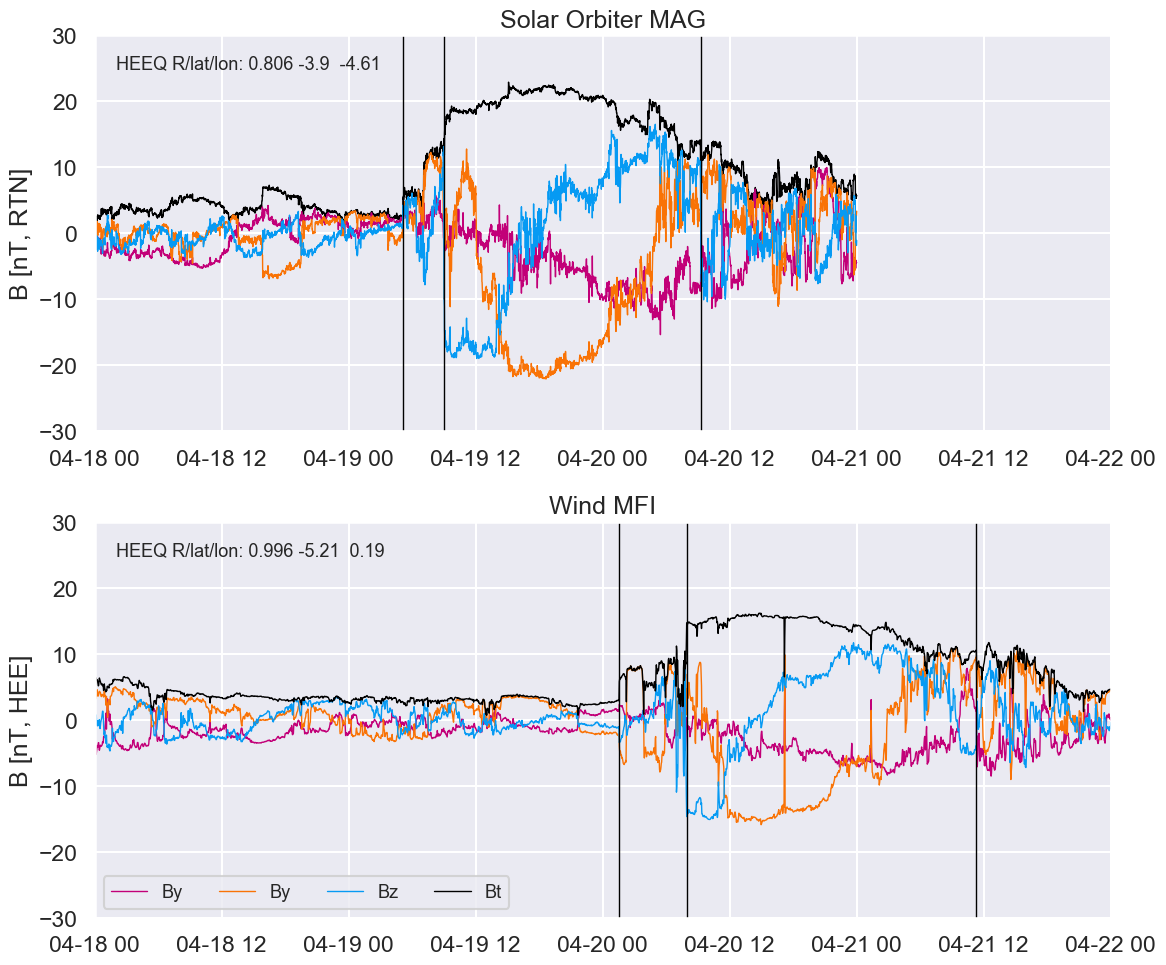

In [3]:
filemag='data/solo_april2020.p'
sm=pickle.load(open(filemag, "rb" ) ) 


filewin='data/wind_2018_now_gse.p'
[win,hwin]=pickle.load(open(filewin, "rb" ) )

#%matplotlib inline

#%matplotlib
#hp.plot_insitu_measure(sm, '2020-Apr-18 12:00','2020-Apr-21 12:00', 'Solo', 'results/')
#hp.plot_insitu_measure(win, '2020-Apr-18 12:00','2020-Apr-23 12:00', 'Wind', 'results/')


print()
print()

#solo
sicme_start_time=parse_time('2020-04-19T05:07Z').datetime
smo_start_time=parse_time('2020-04-19T08:59Z').datetime
smo_end_time=parse_time('2020-04-20T09:15Z').datetime

print('SolO times:',sicme_start_time, smo_start_time,smo_end_time)

#index of times
sicme_start_ind=np.where(sicme_start_time==sm.time)[0][0]
smo_start_ind=np.where(smo_start_time==sm.time)[0][0]
smo_end_ind=np.where(smo_end_time==sm.time)[0][0]

print('HEEQ position of SolO r/lat/lon at icme_start_time:',np.round(sm.r[sicme_start_ind],3),np.round(sm.lat[sicme_start_ind],2),np.round(sm.lon[sicme_start_ind],2))
print('HEEQ position of SolO r/lat/lon at mo_start_time:',np.round(sm.r[smo_start_ind],3),np.round(sm.lat[smo_start_ind],2),np.round(sm.lon[smo_start_ind],2))
print('HEEQ position of SolO r/lat/lon at mo_end_time:',np.round(sm.r[smo_end_ind],3),np.round(sm.lat[smo_end_ind],2),np.round(sm.lon[smo_end_ind],2))



print('SolO ICME duration hours ', np.round((smo_end_time-sicme_start_time).total_seconds()/3600,2))
print('SolO MO duration hours ', np.round((smo_end_time-smo_start_time).total_seconds()/3600,2))
print()

#earth
wicme_start_time=parse_time('2020-04-20T01:34Z').datetime
wmo_start_time=parse_time('2020-04-20T07:56Z').datetime
wmo_end_time=parse_time('2020-04-21T11:18Z').datetime

print('Wind times:',wicme_start_time, wmo_start_time,wmo_end_time)



print('Wind ICME duration hours ', np.round((wmo_end_time-wicme_start_time).total_seconds()/3600,2))
print('Wind MO duration hours ', np.round((wmo_end_time-wmo_start_time).total_seconds()/3600,2))


#index of times
wicme_start_ind=np.where(wicme_start_time==win.time)[0][0]
wmo_start_ind=np.where(wmo_start_time==win.time)[0][0]
wmo_end_ind=np.where(wmo_end_time==win.time)[0][0]

print('HEEQ position of Wind r/lat/lon at icme_start_time:',np.round(win.r[wicme_start_ind],3),np.round(win.lat[wicme_start_ind],2),np.round(win.lon[wicme_start_ind],2))
print('HEEQ position of Wind r/lat/lon at mo_start_time:',np.round(win.r[wmo_start_ind],3),np.round(win.lat[wmo_start_ind],2),np.round(win.lon[wmo_start_ind],2))
print('HEEQ position of Wind r/lat/lon at mo_end_time:',np.round(win.r[wmo_end_ind],3),np.round(win.lat[wmo_end_ind],2),np.round(win.lon[wmo_end_ind],2))





sns.set_context("talk")     
sns.set_style('darkgrid')

plt.figure(3,figsize=(12, 10),dpi=100)

ax = plt.subplot(211)
plt.title('Solar Orbiter MAG')
ax.plot(sm.time, sm.bt, "k-", lw=1)
ax.plot(sm.time, sm.bx, "r-", color="xkcd:magenta", lw=1, label='Bx')
ax.plot(sm.time, sm.by, "g-", color="xkcd:orange", lw=1,label='By')
ax.plot(sm.time, sm.bz, "b-", color="xkcd:azure", lw=1,label='Bz')


    
#plot vertical lines
ax.plot_date([sicme_start_time,sicme_start_time],[-500,500],'-k',linewidth=1)            
ax.plot_date([smo_start_time,smo_start_time],[-500,500],'-k',linewidth=1)            
ax.plot_date([smo_end_time,smo_end_time],[-500,500],'-k',linewidth=1)            



plt.ylabel('B [nT, RTN]')

plotstart=datetime.datetime(2020, 4, 18)
plotend=datetime.datetime(2020, 4,22)
plt.xlim(plotstart,plotend)
plt.ylim(-30,30)


#position on figure
textstart=plotstart+datetime.timedelta(hours=2)
plt.text(textstart,25,'HEEQ R/lat/lon: '+str(np.round(sm.r[sicme_start_ind],3))+' ' +str(np.round(sm.lat[sicme_start_ind],2))+'  '+\
         str(np.round(sm.lon[sicme_start_ind],2)),fontsize=13)





ax2 = plt.subplot(212)
plt.title('Wind MFI')
ax2.plot(win.time, -win.bx,'-r', color="xkcd:magenta",linewidth=1,label='By')
ax2.plot(win.time, -win.by, "g-", color="xkcd:orange", lw=1,label='By')
ax2.plot(win.time, win.bz, "b-", color="xkcd:azure", lw=1,label='Bz')
ax2.plot(win.time, win.bt, "k-", lw=1,label='Bt')

#plot vertical lines
ax2.plot_date([wicme_start_time,wicme_start_time],[-500,500],'-k',linewidth=1)            
ax2.plot_date([wmo_start_time,wmo_start_time],[-500,500],'-k',linewidth=1)            
ax2.plot_date([wmo_end_time,wmo_end_time],[-500,500],'-k',linewidth=1)            



plt.ylabel('B [nT, HEE]')


plotstart=datetime.datetime(2020, 4, 18)
plotend=datetime.datetime(2020, 4,22)
plt.xlim(plotstart,plotend)
plt.ylim(-30,30)


#position on figure
textstart=plotstart+datetime.timedelta(hours=2)
plt.text(textstart,25,'HEEQ R/lat/lon: '+str(np.round(win.r[wicme_start_ind],3))+' ' +str(np.round(win.lat[wicme_start_ind],2))+'  '+\
         str(np.round(win.lon[wicme_start_ind],2)),fontsize=13)

plt.legend(loc=3,ncol=4,fontsize=13)
plt.tight_layout()

plt.savefig('results/solo_wind_cme_april2020.png')
plt.savefig('results/solo_wind_cme_april2020.eps')



In [7]:
#CME 2
DATAPATH = "data/solo_mag/event2"


class SOIO_EXT(heliosat.SOIO):
    def get_data_files(self, *args):
        files = os.listdir(DATAPATH)
        files.sort()
        files = [os.path.join(DATAPATH, f) for f in files]
        return files, [self.get_data_version("mag", datetime.datetime.now())] * len(files)
  

a = SOIO_EXT()
#time for 7 days
time = [datetime.datetime(2020, 5, 27) + datetime.timedelta(minutes=i) for i in range(60 * 24 * 7 )]
time_mat=mdates.date2num(time) 



#_, b_soio = SOIO_EXT().get_data(t_soio, "mag", frame="HEEQ")

# t_soio = [datetime.datetime(2020, 5, 27) + datetime.timedelta(hours=i) for i in range(24 * 7)]
# _, b_soio = SOIO_EXT().get_data(t_soio, "mag", frame="HEEQ", cache=True, smoothing="kernel",
#                                 smoothing_scale=240, remove_nans=True)


#original data
print('get data')
t2, b_soio = SOIO_EXT().get_data(time, "mag")#,frame="HEEQ")
t1=parse_time(t2,format='unix').datetime
tm_mat=mdates.date2num(t1) 

smag=np.zeros(np.size(time),dtype=[('time',object),('bx', float),('by', float),\
        ('bz', float),('bt', float),\
        ('vt', float),('np', float), ('tp', float),\
                                   ('x', float),('y', float),('z', float),\
        ('r', float),('lat', float),('lon', float)])  
smag = smag.view(np.recarray) 

print('interpolate')
smag.time=time
smag.bx = np.interp(time_mat, tm_mat, b_soio[:, 0])
smag.by = np.interp(time_mat, tm_mat, b_soio[:, 1])
smag.bz = np.interp(time_mat, tm_mat, b_soio[:, 2])
smag.bt =np.sqrt(smag.bx**2+smag.by**2+smag.bz**2)


print('Solo position')


#add position

frame='HEEQ'
spice.furnish(spicedata.get_kernel('solo_2020'))
solo=spice.Trajectory('Solar Orbiter')
solo.generate_positions(smag.time, 'Sun',frame)
solo.change_units(astropy.units.AU)
[smag.r, smag.lat, smag.lon]=hd.cart2sphere(solo.x,solo.y,solo.z)


#convert to degree
smag.lat=np.rad2deg(smag.lat)
smag.lon=np.rad2deg(smag.lon)


smag.x=solo.x.value
smag.y=solo.y.value
smag.z=solo.z.value




filemag='data/solo_may2020.p'
pickle.dump(smag, open(filemag, "wb"))

get data
interpolate
Solo position


SolO times: 2020-05-28 12:45:00 2020-05-28 19:44:00 2020-05-29 10:53:00
HEEQ position of SolO r/lat/lon at icme_start_time: 0.561 3.71 28.05
HEEQ position of SolO r/lat/lon at mo_start_time: 0.559 3.78 28.53
HEEQ position of SolO r/lat/lon at mo_end_time: 0.556 3.93 29.57
SolO ICME duration hours  22.13
SolO MO duration hours  15.15

Wind times: 2020-05-29 22:12:00 2020-05-30 04:20:00 2020-05-30 13:16:00
Wind ICME duration hours  15.07
Wind MO duration hours  8.93
HEEQ position of Wind r/lat/lon at icme_start_time: 0.975 -3.41 -0.22
HEEQ position of Wind r/lat/lon at mo_start_time: 0.975 -3.47 -0.22
HEEQ position of Wind r/lat/lon at mo_end_time: 0.975 -3.62 -0.22


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


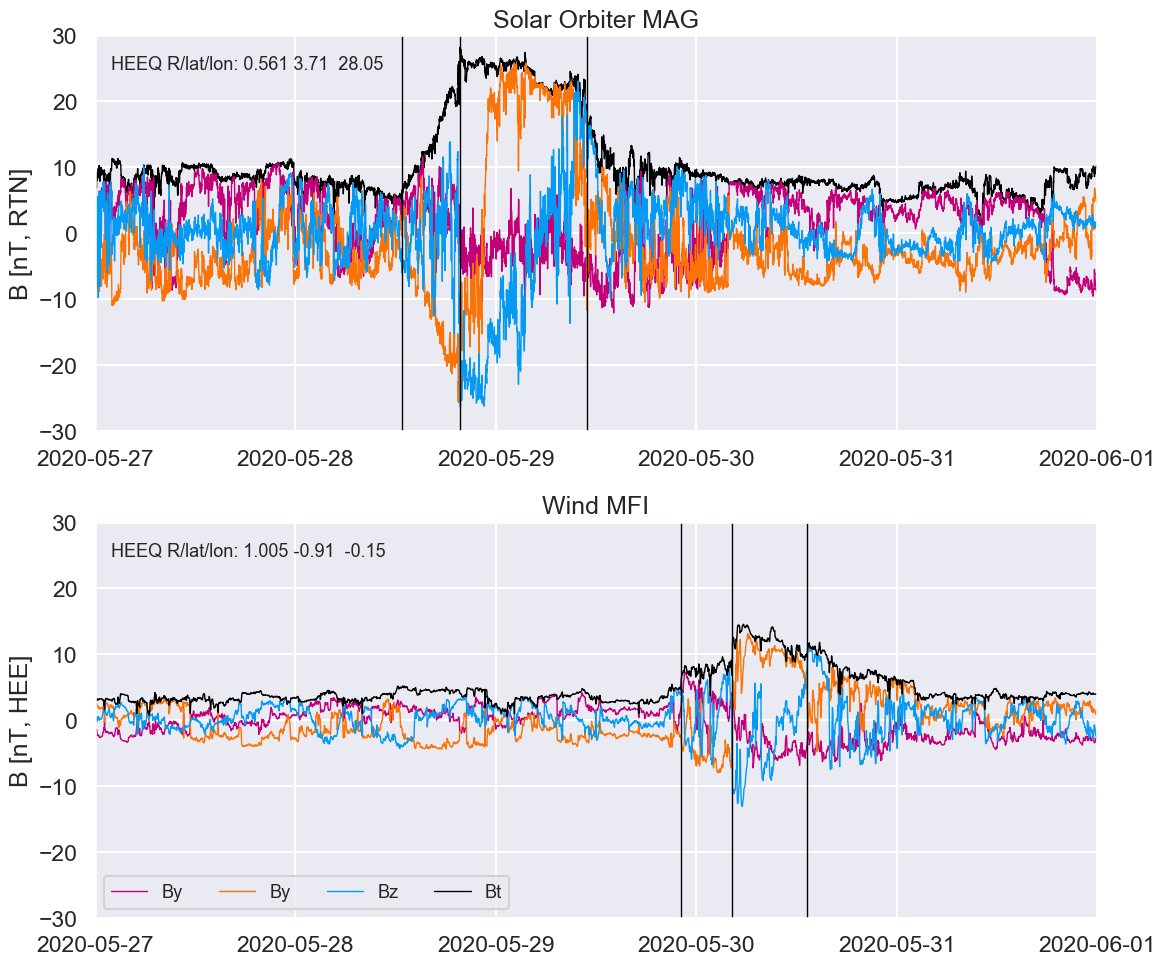

In [5]:
filemag='data/solo_may2020.p'
sm=pickle.load(open(filemag, "rb" ) ) 

filewin='data/wind_2018_now_gse.p'
[win,hwin]=pickle.load(open(filewin, "rb" ) )





#%matplotlib inline

#%matplotlib
#hp.plot_insitu_measure(sm, '2020-May-27 12:00','2020-Jun-2 12:00', 'Solo', 'results/')
#hp.plot_insitu_measure(win, '2020-May-27 12:00','2020-Jun-2 12:00', 'Wind', 'results/')








#solo
sicme_start_time=parse_time('2020-05-28T12:45Z').datetime
smo_start_time=parse_time('2020-05-28T19:44Z').datetime
smo_end_time=parse_time('2020-05-29T10:53Z').datetime

print('SolO times:',sicme_start_time, smo_start_time,smo_end_time)

#index of times
sicme_start_ind=np.where(sicme_start_time==sm.time)[0][0]
smo_start_ind=np.where(smo_start_time==sm.time)[0][0]
smo_end_ind=np.where(smo_end_time==sm.time)[0][0]

print('HEEQ position of SolO r/lat/lon at icme_start_time:',np.round(sm.r[sicme_start_ind],3),np.round(sm.lat[sicme_start_ind],2),np.round(sm.lon[sicme_start_ind],2))
print('HEEQ position of SolO r/lat/lon at mo_start_time:',np.round(sm.r[smo_start_ind],3),np.round(sm.lat[smo_start_ind],2),np.round(sm.lon[smo_start_ind],2))
print('HEEQ position of SolO r/lat/lon at mo_end_time:',np.round(sm.r[smo_end_ind],3),np.round(sm.lat[smo_end_ind],2),np.round(sm.lon[smo_end_ind],2))



print('SolO ICME duration hours ', np.round((smo_end_time-sicme_start_time).total_seconds()/3600,2))
print('SolO MO duration hours ', np.round((smo_end_time-smo_start_time).total_seconds()/3600,2))
print()

#earth
wicme_start_time=parse_time('2020-05-29T22:12Z').datetime
wmo_start_time=parse_time('2020-05-30T04:20Z').datetime
wmo_end_time=parse_time('2020-05-30T13:16Z').datetime

print('Wind times:',wicme_start_time, wmo_start_time,wmo_end_time)



print('Wind ICME duration hours ', np.round((wmo_end_time-wicme_start_time).total_seconds()/3600,2))
print('Wind MO duration hours ', np.round((wmo_end_time-wmo_start_time).total_seconds()/3600,2))


#index of times
wicme_start_ind=np.where(wicme_start_time==win.time)[0][0]
wmo_start_ind=np.where(wmo_start_time==win.time)[0][0]
wmo_end_ind=np.where(wmo_end_time==win.time)[0][0]

print('HEEQ position of Wind r/lat/lon at icme_start_time:',np.round(win.r[sicme_start_ind],3),np.round(win.lat[sicme_start_ind],2),np.round(win.lon[sicme_start_ind],2))
print('HEEQ position of Wind r/lat/lon at mo_start_time:',np.round(win.r[smo_start_ind],3),np.round(win.lat[smo_start_ind],2),np.round(win.lon[smo_start_ind],2))
print('HEEQ position of Wind r/lat/lon at mo_end_time:',np.round(win.r[smo_end_ind],3),np.round(win.lat[smo_end_ind],2),np.round(win.lon[smo_end_ind],2))























sns.set_context("talk")     
sns.set_style('darkgrid')

plt.figure(3,figsize=(12, 10),dpi=100)

ax = plt.subplot(211)
plt.title('Solar Orbiter MAG')
ax.plot(sm.time, sm.bt, "k-", lw=1)
ax.plot(sm.time, sm.bx, "r-", color="xkcd:magenta", lw=1, label='Bx')
ax.plot(sm.time, sm.by, "g-", color="xkcd:orange", lw=1,label='By')
ax.plot(sm.time, sm.bz, "b-", color="xkcd:azure", lw=1,label='Bz')
plt.ylabel('B [nT, RTN]')



#plot vertical lines
ax.plot_date([sicme_start_time,sicme_start_time],[-500,500],'-k',linewidth=1)            
ax.plot_date([smo_start_time,smo_start_time],[-500,500],'-k',linewidth=1)            
ax.plot_date([smo_end_time,smo_end_time],[-500,500],'-k',linewidth=1)            



plotstart=datetime.datetime(2020, 5, 27)
plotend=datetime.datetime(2020, 6,1)
plt.xlim(plotstart,plotend)



#position on figure
textstart=plotstart+datetime.timedelta(hours=2)
plt.text(textstart,25,'HEEQ R/lat/lon: '+str(np.round(sm.r[sicme_start_ind],3))+' ' +str(np.round(sm.lat[sicme_start_ind],2))+'  '+\
         str(np.round(sm.lon[sicme_start_ind],2)),fontsize=13)




plt.ylim(-30,30)



ax2 = plt.subplot(212)
plt.title('Wind MFI')
ax2.plot(win.time, -win.bx,'-r', color="xkcd:magenta",linewidth=1,label='By')
ax2.plot(win.time, -win.by, "g-", color="xkcd:orange", lw=1,label='By')
ax2.plot(win.time, win.bz, "b-", color="xkcd:azure", lw=1,label='Bz')
ax2.plot(win.time, win.bt, "k-", lw=1,label='Bt')
plt.ylabel('B [nT, HEE]')



#plot vertical lines
ax2.plot_date([wicme_start_time,wicme_start_time],[-500,500],'-k',linewidth=1)            
ax2.plot_date([wmo_start_time,wmo_start_time],[-500,500],'-k',linewidth=1)            
ax2.plot_date([wmo_end_time,wmo_end_time],[-500,500],'-k',linewidth=1)            



plotstart=datetime.datetime(2020, 5, 27)
plotend=datetime.datetime(2020, 6,1)
plt.xlim(plotstart,plotend)


#position on figure
textstart=plotstart+datetime.timedelta(hours=2)
plt.text(textstart,25,'HEEQ R/lat/lon: '+str(np.round(win.r[wicme_start_ind],3))+' ' +str(np.round(win.lat[wicme_start_ind],2))+'  '+\
         str(np.round(win.lon[wicme_start_ind],2)),fontsize=13)

plt.ylim(-30,30)



plt.ylabel('B [nT, HEE]')
plt.legend(loc=3,ncol=4)
plt.title('Wind MFI')

plt.legend(loc=3,ncol=4,fontsize=13)



plt.tight_layout()



plt.savefig('results/solo_wind_cme_may2020.png')
plt.savefig('results/solo_wind_cme_may2020.eps')

